In [1]:
import matplotlib
import matplotlib.pyplot as plt
import imageio

In [2]:
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [4]:
# Set use_cuda=True to use an available GPU
use_cuda=True

In [5]:
# Set use_exact_model=True to use a model parameterized
# exactly like the analytic solution
use_exact_model=True

Text(0.5, 0, 'Input')

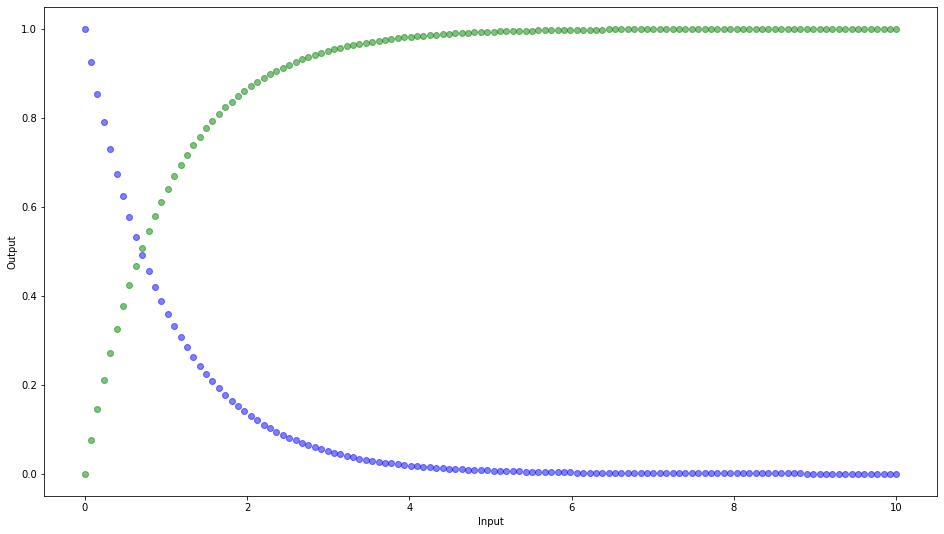

In [6]:
# generate NumSamples for training
NumSamples = 128

# let's look at a range in x from [0, 10]
xmin = 0
xmax = 10.0

# the range of the solution values is [0,1]
ymin = 0
ymax = 1

x = torch.unsqueeze(torch.linspace(xmin, xmax, NumSamples, requires_grad=True), dim=1)
x_test = torch.unsqueeze(torch.rand(NumSamples, requires_grad=True), dim=1) * (xmax-xmin) + xmin

# initial conditions at "time" 0
y0_t0 = 1
y1_t0 = 0

# exponential decay constant
exp_A = 1

# ya & yb are tensors that let us express the analytic
# solution of the system in matrix form
ya = torch.ones(1,2)
ya[0][0] =  y0_t0
ya[0][1] = -y0_t0

yb = torch.ones(1,2)
yb[0][0] = 0
yb[0][1] = y0_t0 + y1_t0

# this is the analytic solution of the system as a function of x
def sol(_x):
    return torch.exp(-exp_A * _x) * ya + yb

# this is the analytic derivative of the system w.r.t. x
def rhs(_y):
    return -exp_A * (_y - yb)

# if we're using cuda, then put the tensors
# in our workspace on the GPU.
if use_cuda:
    x = x.cuda()
    x_test = x_test.cuda()
    yb = yb.cuda()
    ya = ya.cuda()

# get the analytic solution as a function of x
y = sol(x)

# get the analytic right-hand-side as a function of y(x)
# f(x) = dy(x)/dx
dydx = rhs(y)

# get the analytic solution at the test points x_test
y_test = sol(x_test)
    
# we will want to propagate gradients through y, dydx, and x
# so make them PyTorch Variables
x = Variable(x, requires_grad=True)
y = Variable(y, requires_grad=True)
dydx = Variable(dydx, requires_grad=True)

# we will need to evaluate gradients w.r.t. x multiple
# times so tell PyTorch to save the gradient variable in x.
x.retain_grad()

fig, axis = plt.subplots(figsize=(16,9))

# get numpy versions of x,y,f on the cpu for plotting
xnp = x.cpu().data.numpy()
ynp = y.cpu().data.numpy()
fnp = dydx.cpu().data.numpy()

# plot the components of the solution
axis.scatter(xnp, ynp[:,0],
             color='blue', alpha=0.5)

axis.scatter(xnp, ynp[:,1],
             color='green', alpha=0.5)

axis.set_ylabel("Output")
axis.set_xlabel("Input")

In [7]:
class HiddenNet(nn.Module):
    def __init__(self, n_independent, n_dependent,
                 n_hidden, hidden_depth, activation):
        super(HiddenNet, self).__init__()
        
        self.activation = activation
        self.input_layer = nn.Linear(n_independent, n_hidden)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_depth):
            self.hidden_layers.append(nn.Linear(n_hidden, n_hidden))
        self.output_layer = nn.Linear(n_hidden, n_dependent)
        
    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for h in self.hidden_layers:
            x = self.activation(h(x))
        x = self.output_layer(x)
        return x

In [8]:
class ExactModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.y0_0 = torch.nn.Parameter(torch.tensor(1.0))
        self.y1_0 = torch.nn.Parameter(torch.tensor(1.0))
        self.a = torch.nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        # ya & yb are tensors that let us express the analytic
        # solution of the system in matrix form
        ya = torch.ones(1,2)
        ya[0][0] =  self.y0_0
        ya[0][1] = -self.y0_0

        yb = torch.ones(1,2)
        yb[0][0] = 0
        yb[0][1] = self.y0_0 + self.y1_0
        
        if use_cuda:
            ya = ya.cuda()
            yb = yb.cuda()

        return torch.exp(-self.a * x) * ya + yb

In [9]:
if use_exact_model:
    net = ExactModel()
else:
    net = HiddenNet(n_independent=1, n_dependent=2,
                    n_hidden=2, hidden_depth=0, activation=F.celu)

In [10]:
if use_cuda:
    net.cuda()

In [11]:
print(net)

ExactModel()


In [12]:
optimizer_sgd = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer_adam = torch.optim.Adam(net.parameters(), lr=0.01)

In [13]:
loss_func = torch.nn.MSELoss()

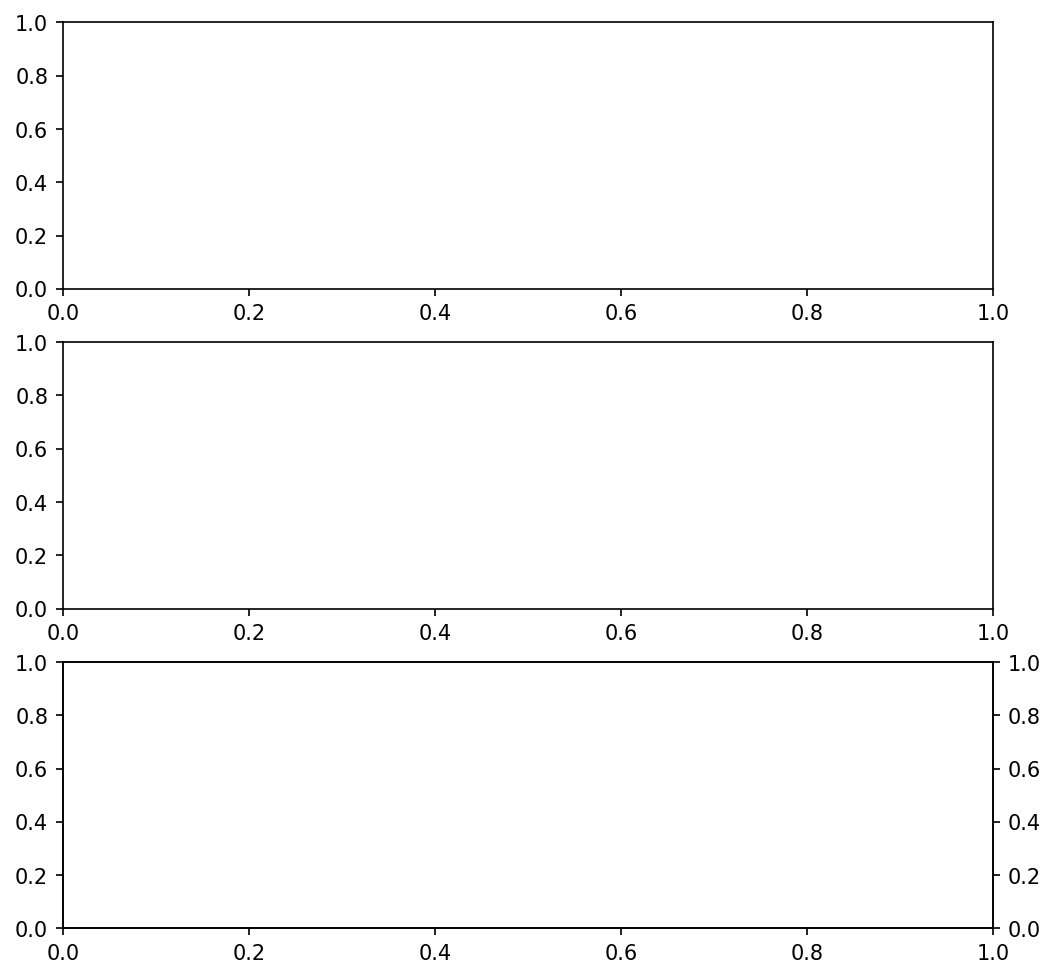

In [14]:
training_images = []
# get a multipanel figure showing the prediction (p) and error (e)
fig, (axis_p, axis_f, axis_e) = plt.subplots(nrows=3, ncols=1, figsize=(8,8), dpi=150)
axis_e1 = axis_e.twinx()

In [15]:
# arrays for accumulating the epoch index and losses for plotting
epochs = []
losses = []
losses0 = []
losses1 = []
tlosses = []

In [16]:
# this function is the training loop over epochs
# where 1 epoch trains over the whole training dataset
def train_error(NumEpochs):
    for t in range(NumEpochs):
        # calculate prediction given the current net state
        prediction = net(x)
        
        # get error with testing samples
        prediction_test = net(x_test)
        test_loss = torch.sqrt(loss_func(prediction_test, y_test)).cpu().data.numpy()

        # calculate error between prediction and analytic truth y
        loss0 = torch.sqrt(loss_func(prediction, y))

        # calculate gradients d(prediction)/d(x) for each component

        # first, zero out the existing gradients to avoid
        # accumulating gradients on top of existing gradients
        net.zero_grad()

        if x.grad is not None:
            x.grad.data.zero_()

        # now get the gradients dp0/dx
        prediction[:,0].backward(torch.ones_like(prediction[:,0]), retain_graph=True)
        # clone the x gradient to save a copy of it as dp0/dx
        dp0dx = x.grad.clone()
        # clear the x gradient for the loss gradient below
        x.grad.data.zero_()
        
        # get gradient dp1/dx
        prediction[:,1].backward(torch.ones_like(prediction[:,1]), retain_graph=True)
        # clone the x gradient to save a copy of it as dp1/dx
        dp1dx = x.grad.clone()
        # clear the x gradient for the loss gradient below
        x.grad.data.zero_()
        
        dpdx = torch.ones_like(prediction)
        dpdx[:,0] = torch.flatten(dp0dx)
        dpdx[:,1] = torch.flatten(dp1dx)
        
        # evaluate the analytic right-hand-side function at the prediction value
        prhs = rhs(prediction)

        # define the error of the prediction derivative using the analytic derivative
        loss1 = torch.sqrt(loss_func(dpdx, dydx))
        
        # the following doesn't work well :/
        #loss1 = torch.sqrt(loss_func(dpdx, rhs(prediction)))

        # total error combines the error of the prediction (loss0) with 
        # the error of the prediction derivative (loss1)
        loss = loss0 + loss1

        # use the Adam optimizer
        optimizer = optimizer_adam

        # clear gradients for the next training iteration
        optimizer.zero_grad()

        # compute backpropagation gradients
        loss.backward()

        # apply gradients to update the weights
        optimizer.step()

        # generate plots
        if t % 100 == 0:
            # Prediction plot to show learning progress
            axis_p.clear()

            axis_p.set_ylabel('Solution', fontsize=22)

            pnp = prediction.cpu().data.numpy()
            
            axis_p.plot(xnp, pnp[:,0],
                        'orange', lw=3, alpha=0.5)
            
            axis_p.plot(xnp, pnp[:,1],
                        'red', lw=3, alpha=0.5)
            
            axis_p.scatter(xnp, ynp[:,0],
                           color='blue', alpha=0.5, s=20)

            axis_p.scatter(xnp, ynp[:,1],
                           color='green', alpha=0.5, s=20)
            
            # Plot analytic rhs vs prediction rhs
            pfnp = prhs.cpu().data.numpy()
            dpdxnp = dpdx.cpu().data.numpy()
            axis_f.clear()

            axis_f.set_ylabel('Gradient', fontsize=22)
            
            axis_f.plot(xnp, pfnp[:,0],
                        'orange', lw=3, alpha=0.5)
            
            axis_f.plot(xnp, pfnp[:,1],
                        'red', lw=3, alpha=0.5)
            
            axis_f.plot(xnp, dpdxnp[:,0],
                        'magenta', lw=3, ls=':', alpha=0.5)
            
            axis_f.plot(xnp, dpdxnp[:,1],
                        'black', lw=3, ls=':', alpha=0.5)

            axis_f.scatter(xnp, fnp[:,0],
                           color='blue', alpha=0.5, s=20)

            axis_f.scatter(xnp, fnp[:,1],
                           color='green', alpha=0.5, s=20)
            
            axis_f.tick_params(axis='both', which='major', labelsize=16)

            # get min/max in x/y to set label positions relative to the axes
            height = np.abs(ymax - ymin)
            width = np.abs(xmax - xmin)

            axis_p.set_xlim(xmin, xmax)
            axis_p.set_ylim(ymin, ymax)

            axis_p.text(xmin, ymax + height*0.3,
                      'Step = %d' % t, fontdict={'size': 24, 'color': 'blue'})
            axis_p.text(xmin + width*0.5, ymax + height*0.3,
                      'Train Loss = %.2e' % loss.cpu().data.numpy(),
                      fontdict={'size': 24, 'color': 'blue'})
            axis_p.text(xmin + width*0.5, ymax + height*0.1,
                      'Test Loss = %.2e' % test_loss,
                      fontdict={'size': 24, 'color': 'orange'})

            axis_p.tick_params(axis='both', which='major', labelsize=16)

            # plot errors evolving with the number of epochs trained
            epochs.append(t)
            losses.append(loss.cpu().data.numpy())
            losses0.append(loss0.cpu().data.numpy())
            losses1.append(loss1.cpu().data.numpy())
            tlosses.append(test_loss)

            axis_e.clear()
            axis_e1.clear()

            axis_e.set_xlabel('Epoch', fontsize=22)
            axis_e.set_ylabel('Error 0', fontsize=22)

            axis_e.scatter([epochs[-1]], [losses0[-1]],
                           color="red", alpha=0.5)
            axis_e.plot(epochs, losses0,
                        'b-', lw=3, alpha=0.5)

            axis_e.scatter([epochs[-1]], [test_loss],
                           color="red", alpha=0.5)
            axis_e.plot(epochs, tlosses,
                        'orange', lw=3, ls="--", alpha=0.5)

            axis_e1.set_ylabel('Error 1', fontsize=22)

            axis_e1.scatter([epochs[-1]], [losses1[-1]],
                           color="red", alpha=0.5)
            axis_e1.plot(epochs, losses1,
                         'g-', lw=3, alpha=0.5)
            
            axis_e.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: "{:0.1f}".format(x)))
            
            axis_e1.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: "{:0.1f}".format(x)))

            axis_e.tick_params(axis='both', which='major', labelsize=16)
            axis_e1.tick_params(axis='both', which='major', labelsize=16)

            # Draw on canvas and save image in sequence
            fig.canvas.draw()
            plt.tight_layout()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            training_images.append(image)

            # Print epoch/error notifications
            if t % 100 == 0:
                print('epoch ', t, ' with error: ', losses[-1])
           
        # Stop early if our errors are plateauing
        if t > 1000:
            # do a quadratic polynomial fit and see if we will
            # need more than NumEpochs for the error e to vanish:
            # e / (d(e)/d(epoch)) > NumEpochs ?
            # if so, then break out of the training loop ...
            xfit = epochs[-4:]
            efit = losses[-4:]
            coef = np.polyfit(xfit, efit, 2)
            
            if coef[2]/coef[1] > NumEpochs:
                break

In [17]:
train_error(2000)

epoch  0  with error:  0.70710677
epoch  100  with error:  0.20751274
epoch  200  with error:  0.080945626
epoch  300  with error:  0.002778283
epoch  400  with error:  0.0028294441
epoch  500  with error:  0.0021544914
epoch  600  with error:  0.0025239375
epoch  700  with error:  0.0021363287
epoch  800  with error:  0.0019371274
epoch  900  with error:  0.002331865
epoch  1000  with error:  0.00198957
epoch  1100  with error:  0.0018419715
epoch  1200  with error:  0.00223655
epoch  1300  with error:  0.0019419816
epoch  1400  with error:  0.0017791735
epoch  1500  with error:  0.0021720626
epoch  1600  with error:  0.0019303416
epoch  1700  with error:  0.001729755
epoch  1800  with error:  0.0021202695
epoch  1900  with error:  0.0019360224


<Figure size 432x288 with 0 Axes>

In [18]:
imageio.mimsave('./regression.gif', training_images, fps=10)

In [19]:
print("final test sample error: ", tlosses[-1])

final test sample error:  0.0015357822
